In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('ticks')

# Equação de condução do calor 2D

Considere a equação do calor bidimensional em regime transiente, dependente do tempo $t$ (s), sem fontes geradoras de calor

$$
\rho c_p \frac{\partial T}{\partial t} = \frac{\partial}{\partial x}
    \left (k_x \frac{\partial T}{\partial x} \right ) +
    \frac{\partial}{\partial y}
    \left (k_y \frac{\partial T}{\partial y} \right )
$$

que relaciona a temperatura $T$ (K ou °C) do material com a sua capacidade térmica $c_p$ (J/(kg·K)), densidade $\rho$ (kg/m³) e condutividade térmica $k_{x,y}$ (W/(m·K)) ao longo do espaço nas direções $x$ (m) e $y$ (m).

Considerando que as propriedades térmicas e densidade do material não variam no espaço (condução isotrópica de calor, ou seja, $k_x = k_y = k$) essa equação pode ser simplificada como

$$
\frac{\partial T}{\partial t} = \kappa \left (
    \frac{\partial^2 T}{\partial x^2}  +\frac{\partial^2 T}{\partial y^2}
    \right )
$$

com a difusividade térmica (m²/s) dada por

$$
\kappa = \frac{k}{\rho c_p}.
$$

## Discretização por diferenças finitas explicitas

Discretizando o espaço em intervalos $\Delta x$, $\Delta y$ o tempo em intervalos $\Delta t$, obtem-se a equação do regime transiente do calor por diferenças finitas

$$
\frac{T_{i,j}^{n+1} - T_{i,j}^{n}}{\Delta t} = \kappa
    \left (
        \frac{T_{i,j+1}^{n} - 2 T_{i,j}^{n} + T_{i,j-1}^{n}}{(\Delta x)^2} +
        \frac{T_{i+1,j}^{n} - 2 T_{i,j}^{n} + T_{i-1,j}^{n}}{(\Delta y)^2}
    \right )
$$

$$
T_{i,j}^{n+1} =  T_{i,j}^{n} + \lambda_x ( T_{i,j+1}^{n} - 2 T_{i,j}^{n} + T_{i,j-1}^{n} ) +
        \lambda_y ( T_{i+1,j}^{n} - 2 T_{i,j}^{n} + T_{i-1,j}^{n} )
$$

que relaciona temperatura $T_{i,j}^n$ no ponto $i,j$ e no tempo $n$ com as constantes

$$
\lambda_x = \frac{\kappa \Delta t}{(\Delta x)^2}
$$

e

$$
\lambda_y = \frac{\kappa \Delta t}{(\Delta y)^2}.
$$

Nesse caso, o esquema explicito somente é estável se

$$
\max(\lambda_x, \lambda_y) \leq \frac{1}{2}
$$

## Parâmetros físicos para o problema

Nesse caso, vamos considerar uma chapa de aluminio parametrizada e discretizada conforme abaixo. Também estamos considerando temperaturas constantes (Dirichlet) em cada um dos lados do domínio (retângulo em coordenadas cartesianas). 

In [3]:
dx = 0.01 # m
dy = 0.01 # m
dt = 0.1 # s

nx = 101 # número de intervalos no eixo x
ny = 101 # número de intervalos no eixo y
nt = 101 # número de intervalos de tempo

T_l = 100 #°C - Temperatura do lado esquerdo da chapa
T_r = 50 #°C - Temperatura do lado esquerdo da chapa
T_u = 25 #°C - Temperatura de cima da chapa
T_d = 75 #°C - Temperatura de baixo da chapa


K = 9.7 * 1e-5 # Difusividade térmica do aluminio (m²/s)
               # fonte: www.electronics-cooling.com/2007/08/thermal-diffusivity/

In [4]:
lbd_x = K * dt/dx**2 # Constante lambda x
lbd_y = K * dt/dy**2 # Constante lambda y

assert lbd_x < 0.5 # Condição de estabilidade eixo x
assert lbd_y < 0.5 # Condição de estabilidade eixo y

## Parâmetros para mostrar os resultados

In [5]:
# Comprimento e largura da barra
T = np.zeros((nx, ny))
x = np.arange(nx) * dx # m
y = np.arange(ny) * dy # m
extent = [x.min(), x.max(), y.min(), y.max()]

number_of_plots = 10

snapshots = np.array_split(np.arange(nt),number_of_plots)
snapshots = list(map(lambda x: x[0], snapshots))
snapshots += [nt - 1]

snapshots = np.array(snapshots)


T_snapshot = np.zeros((T.shape[0], T.shape[1], len(snapshots)))

## Implementação inocente

Essa implementação usa um laço simples para implementar a equação

$$
T_{i,j}^{n+1} =  T_{i,j}^{n} + \lambda_x ( T_{i,j+1}^{n} - 2 T_{i,j}^{n} + T_{i,j-1}^{n} ) +
        \lambda_y ( T_{i+1,j}^{n} - 2 T_{i,j}^{n} + T_{i-1,j}^{n} )
$$

veja que isso não é o recomendado em Python.

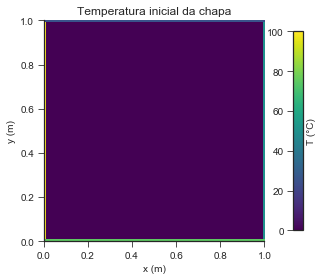

In [6]:
# Inicializando a temperatura da chapa
T = np.zeros((nx, ny))
T[:,0] = T_l
T[:,-1] = T_r
T[0,:] = T_u
T[-1,:] = T_d

im = plt.imshow(T, cmap='viridis', interpolation='nearest', 
                extent=extent)
plt.colorbar(im,  shrink=0.9, pad = 0.07, label=u'T (°C)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(u'Temperatura inicial da chapa')
sns.despine()
plt.tight_layout()

In [7]:
# Loop implementando as diferenças finitas
for n in np.arange(nt):
    for i in np.arange(1, nx -1):
        for j in np.arange(1, ny -1):
            T[i,j] += lbd_x * (T[i,j+1] - 2*T[i,j] + T[i,j-1]) +\
                      lbd_y * (T[i+1,j] - 2*T[i,j] + T[i-1,j])
    if n in snapshots:
        T_snapshot[:,:,np.argwhere(snapshots == n)[0][0]] = T[:,:]

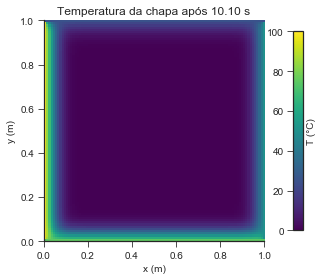

In [8]:
im = plt.imshow(T, cmap='viridis', interpolation='nearest',
               extent=extent)
plt.colorbar(im,  shrink=0.9, pad = 0.07, label=u'T (°C)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(u'Temperatura da chapa após %.2f s' % (nt*dt))
sns.despine()
plt.tight_layout()

## Animação com o resultado da propagação de calor

In [9]:
import matplotlib.animation

In [10]:
fig = plt.figure()
im = plt.imshow(T_snapshot[:,:,0], cmap='viridis', interpolation='nearest',
               extent=extent)
plt.colorbar(im,  shrink=0.9, pad = 0.07, label=u'T (°C)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
title = plt.title(u'Temperatura da chapa')
sns.despine()
plt.tight_layout()
plt.close()

def animate(i):
    im.set_data(T_snapshot[:,:,i])
    title.set_text(u'Temperatura da chapa - %.2f' % (snapshots[i] * dt))

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(snapshots))

from IPython.display import HTML
HTML(ani.to_jshtml())

## Implementação menos inocente usando convolução

Essa implementação usa convolução bidimensional ao invés do laço simples,
desse modo a equação de condução do calor pode ser reescrita como

$$
T^{n+1} =  T^{n} + \lambda_x T^{n} *
    \begin{bmatrix}
1 \\
-2 \\
1
         \end{bmatrix} +
           \lambda_y T^{n} * [1,-2,1]
$$

esse método é bem mais eficiente que o laço simples, especialmente para
muitas amostras.

In [11]:
from scipy.ndimage.filters import convolve1d

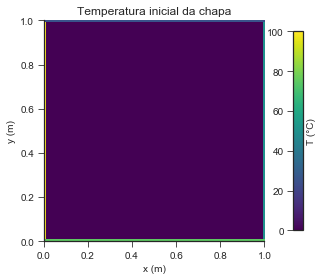

In [12]:
# Inicializando a temperatura da chapa
T = np.zeros((nx, ny))
T[:,0] = T_l
T[:,-1] = T_r
T[0,:] = T_u
T[-1,:] = T_d

im = plt.imshow(T, cmap='viridis', interpolation='nearest', extent=extent)
plt.colorbar(im,  shrink=0.9, pad = 0.07, label=u'T (°C)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(u'Temperatura inicial da chapa')
sns.despine()
plt.tight_layout()

In [13]:
kernel = np.array([1,-2,1]) # Convolution kernel

# Loop implementando as diferenças finitas
for n in np.arange(nt):
    T[1:-1,1:-1] += lbd_x * convolve1d(T,kernel, axis=0, mode='wrap')[1:-1,1:-1] +\
                    lbd_y * convolve1d(T,kernel, axis=1, mode='wrap')[1:-1,1:-1]
    if n in snapshots:
        T_snapshot[:,:,np.argwhere(snapshots == n)[0][0]] = T[:,:]

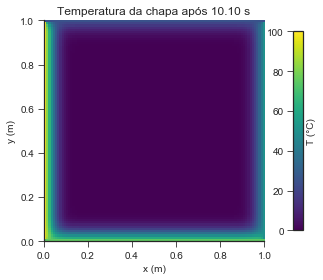

In [14]:
im = plt.imshow(T, cmap='viridis', interpolation='nearest', extent=extent)
plt.colorbar(im,  shrink=0.9, pad = 0.07, label=u'T (°C)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(u'Temperatura da chapa após %.2f s' % (nt*dt))
sns.despine()
plt.tight_layout()

## Animação com o resultado da propagação de calor

In [15]:
fig = plt.figure()
im = plt.imshow(T_snapshot[:,:,0], cmap='viridis', interpolation='nearest', extent=extent)
plt.colorbar(im,  shrink=0.9, pad = 0.07, label=u'T (°C)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
title = plt.title(u'Temperatura da chapa')
sns.despine()
plt.tight_layout()
plt.close()

def animate(i):
    im.set_data(T_snapshot[:,:,i])
    title.set_text(u'Temperatura da chapa - %.2f' % (snapshots[i] * dt))

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(snapshots))

from IPython.display import HTML
HTML(ani.to_jshtml())

## Comparando a velocidade das implementações

### Implementação usando laços

In [16]:
%%timeit

# Inicializando a temperatura da chapa
T = np.zeros((nx, ny))
T[:,0] = T_l
T[:,-1] = T_r
T[0,:] = T_u
T[-1,:] = T_d

# Loop implementando as diferenças finitas
for n in np.arange(nt):
    for i in np.arange(1, nx -1):
        for j in np.arange(1, ny -1):
            T[i,j] += lbd_x * (T[i,j+1] - 2*T[i,j] + T[i,j-1]) +\
                      lbd_y * (T[i+1,j] - 2*T[i,j] + T[i-1,j])

1 loop, best of 3: 3.18 s per loop


In [17]:
%%timeit

# Inicializando a temperatura da chapa
T = np.zeros((nx, ny))
T[:,0] = T_l
T[:,-1] = T_r
T[0,:] = T_u
T[-1,:] = T_d

kernel = np.array([1,-2,1]) # Convolution kernel

# Loop implementando as diferenças finitas
for n in np.arange(nt):
    T[1:-1,1:-1] += lbd_x * convolve1d(T,kernel, axis=0, mode='wrap')[1:-1,1:-1] +\
                    lbd_y * convolve1d(T,kernel, axis=1, mode='wrap')[1:-1,1:-1]

100 loops, best of 3: 19.2 ms per loop
